In [180]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import cv2
import h5py
import pickle
import sys
import scipy.io
from scipy.spatial import distance
from scipy.stats import zscore
from scipy.stats import zmap
%matplotlib inline

dir = r"D:\2024-01-08_ALC6_day4"
data_path = os.path.join(dir, '02-processed')
npy_path = os.path.join(dir, '00-npy files')
raw_path = os.path.join(dir, '01-raw')

## 0.1 Function to import phy-adjusted kilosort data.

In [181]:
def importphy(folderpath, tipDepth=4000, sampleRate=30000):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to kilosort output
        2. `tipDepth` - int/float, depth of the shank tip in microns (Reading of D axis given by sensapex micromanipulator)
        3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `goodSpikes` - ndarray of clusters (unit identities of spikes)
        3. `goodSamples` - ndarray of spike samples (time of spike)
        4. `goodTimes` - ndarray of spike times (in s)
        5. `clusterIDs` - ndarray of unit index as listed in the Kilosort/Phy output
        6. `goodIDs` - ndarray of all units included in goodSpikes
        7. `depths` - ndarray of recording site depth, order match with `clusterID` (counting the depth of shank)
        8. `nSpikes` - ndarray of number of spikes 

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
        2. `depthIndices` - index of good units in the order of their depth
        3. `layers` - the cortical layer to which the depth corresponds
        4. 'waveforms of unit at its best site'
    """
    # parameters
    tipLength = 175 # the tip length of neuropixel 1.0 [unit: µm]

    # import the Kilosort data
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # apply label from manual curation 
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    # store units with good qualities
    try:
        goodIDs = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        goodIDs = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # compute the depth
        siteDepth = tipDepth - tipLength - np.array(clusterInfo['depth'])
        if any(depth < 0 for depth in siteDepth):
            print("Warning: Negative depth value found, changing to 0.")
            siteDepth = [0 if depth < 0 else depth for depth in siteDepth]

    # write the output
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['goodSpikes'] = spikeClusters[np.array([n in goodIDs for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in goodIDs for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['clusterIDs'] = np.array(clusterInfo['cluster_id']) ## to get a list of cluster ids
    outDict['goodIDs'] = goodIDs
    outDict['depths'] =  siteDepth
    outDict['nSpikes'] = np.array(clusterInfo['n_spikes']) ## to get number of spikes 
    #outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth

    # print the number of good neurons
    print("Number of neurons passing the quality check: {}".format(len(goodIDs)))

    # report the sampling frequency
    print("Sampling frequency: {} Hz.".format(outDict['sampleRate']))
    
    return outDict

In [182]:
spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)

goodSamples = spikeDict['goodSamples']
goodSpikes = spikeDict['goodSpikes']
goodTimes = spikeDict['goodTimes']
sampleRate = spikeDict['sampleRate']

Number of neurons passing the quality check: 338
Sampling frequency: 30000 Hz.


In [183]:
def importnpy(dir):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to folder containing numpy arrays from NP_Optical trials
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `mechTrialForce` - array of all successfully recorded trials and their forces
        3. `mechTrials` - int of the number of successfully recorded mech trials
        

        ## Not yet implemented
        

    """
    import os
    import numpy as np
    import re

    data_path = os.path.join(dir, '02-processed').replace('\\', '/')
    npy_path = os.path.join(dir, '00-npy files').replace('\\', '/')
    raw_path = os.path.join(dir, '01-raw').replace('\\', '/')
    


    def mechTrialForce ():
        npy_files = [item for item in os.listdir(npy_path)]
        mech_files = [file for file in npy_files if 'mC_ai_data' in file]
        
        #1 sorting function to extract trial forces
        def sort_key(file):
            match = re.search(r'_(\d+).npy$', file)
            return int(match.group(1)) if match else float('inf')

        # Sort the mech trial files using the custom sorting function
        sorted_files = sorted(mech_files, key=sort_key)

        #extract forces in the proper trial order
        npy_Forces = []
        for sorted_file in sorted_files:
            match = re.search(r'_(\d+)mN_', sorted_file)
            force = int(match.group(1)) if match else None
            npy_Forces.append(force)


        #2 Extract trial numbers from successfully recorded mech trials (OpenEphys)
        recording_path = os.path.join(raw_path, '1-mechanical').replace('\\', '/')
        recordings = [item for item in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, item))]
        recordings = sorted(recordings, key=lambda x: int(''.join(filter(str.isdigit, x))))

        # regex search of recordings for successfully recorded mech trials
        pattern = re.compile(r'recording(\d+)')
        successfulRecordings = []
        for recording in recordings:
            match = pattern.search(recording)
            if match:
                successfulRecordings.append(int(match.group(1)))

        # sort/return successfulRecordings list
        successfulRecordings = sorted(successfulRecordings)

        #list and export the forces for only the successfully recorded mech trial files
        mechTrialForce = [npy_Forces[i - 1] for i in successfulRecordings]

        return mechTrialForce

    
    
    
    mechTrialForce = mechTrialForce()

    #Exports
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['mechTrialForce'] = mechTrialForce
    outDict['mechTrials'] = len(mechTrialForce)

    return outDict

In [184]:
npyDict = importnpy(dir)

mechTrialForce = npyDict['mechTrialForce']


print(mechTrialForce)
print(len(mechTrialForce))

[100, 100, 200, 200, 200, 50, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 50, 50, 200, 200, 50, 50, 100, 200, 200, 100, 200, 100, 50, 200, 50, 50, 50, 50, 100, 50, 100, 50, 200, 200, 100, 50, 100, 50, 200, 100, 100, 100, 50, 200, 50, 50, 100, 100, 200, 200, 50, 200, 100, 200, 50, 200, 200, 50, 200, 200, 50, 100, 200, 100, 100, 100, 50, 200, 50, 100, 100, 50, 200, 50, 100, 50, 100, 100, 100, 100, 100, 100, 50, 50, 100, 200, 50, 100, 200, 100, 100, 50, 50, 50, 50, 200, 100, 200, 50, 50, 200, 50, 100, 100, 200, 50, 50, 200, 100, 50, 50, 100, 50, 200, 200, 50, 50, 100, 100, 200, 100, 50, 100, 200, 200, 200, 200, 50, 100, 100, 100, 200, 200, 50, 100, 200, 200, 200, 50, 50, 200, 100, 50, 100, 200, 100, 50, 200, 200, 200, 50, 50, 200, 50, 200, 50, 100, 200, 100, 50, 100, 200]
168


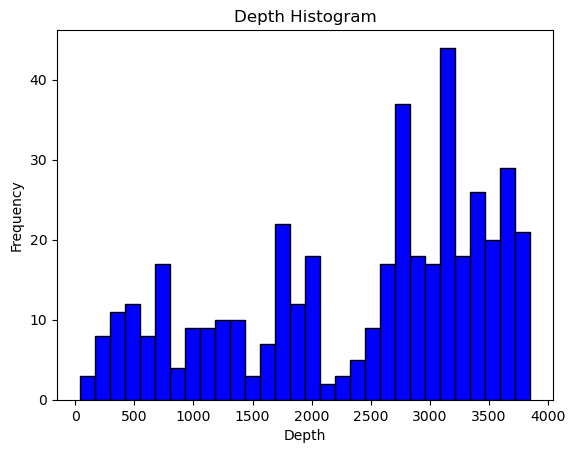

In [185]:
# Plotting the histogram
plt.hist(depths, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Depth Histogram')

# Display the histogram
plt.show()

## 0.2 Plotting all units to ensure proper import.

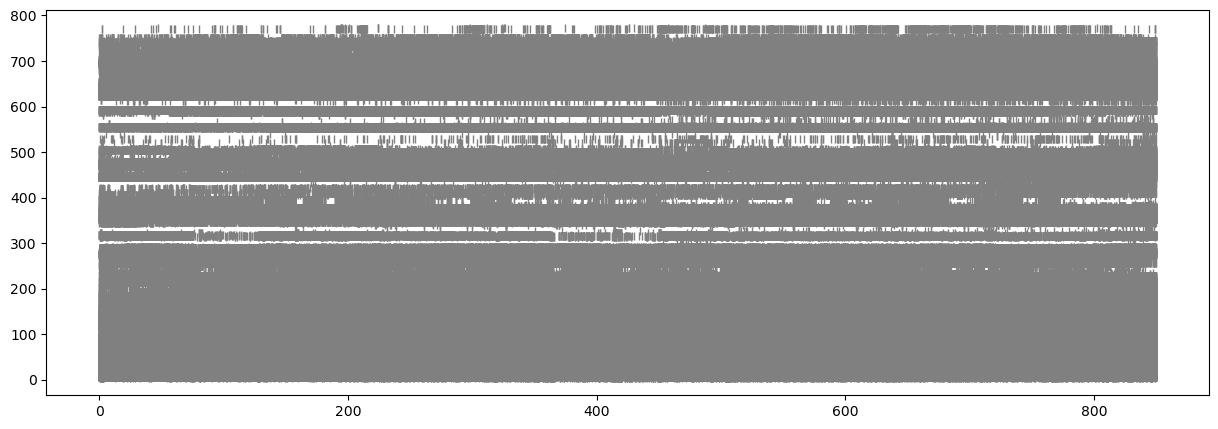

In [186]:
ltime = 0 # in seconds
rtime = 850 # in seconds

#plt.plot(goodtimes,goodspikes,'|')
plt.figure(figsize=(15,5))
plt.plot(goodTimes[(goodTimes > ltime) & (goodTimes < rtime)],goodSpikes[(goodTimes > ltime) & (goodTimes < rtime)],'|',color='gray')

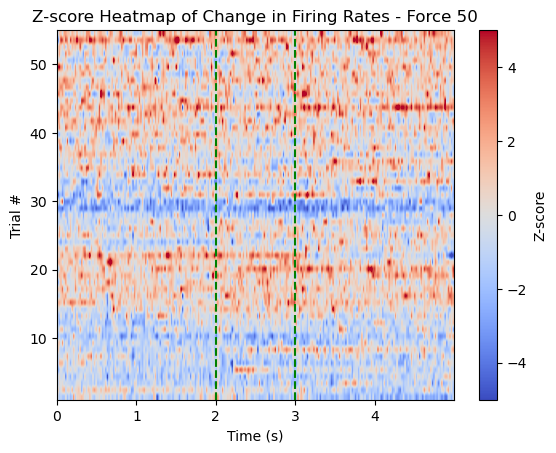

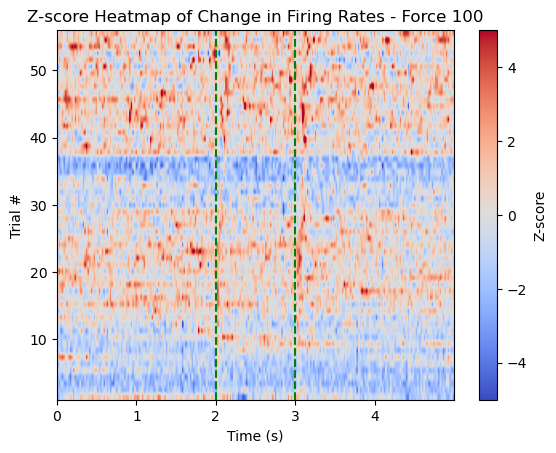

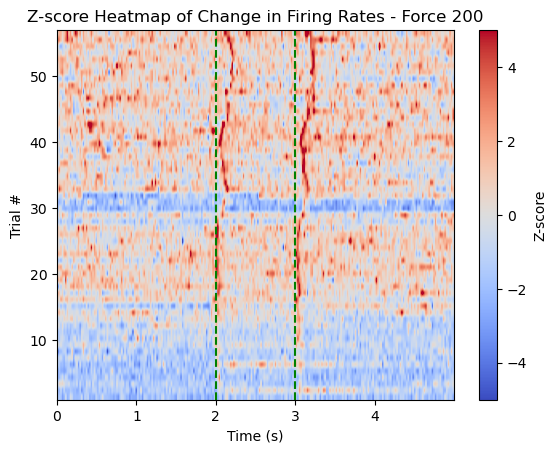

In [187]:
#Plot all mech trials (separated by force)
# Define trial parameters
trial_duration = 4.998  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = len(mechTrialForce)
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # Find indices within range
    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]



# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(mechTrialForce)

for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(mechTrialForce == force)[0]
    force_change_in_firing_rates = change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    
    # Plotting
    time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}')
    plt.show()

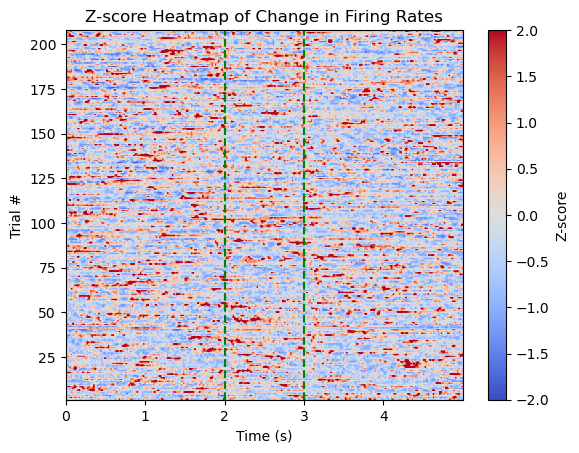

In [111]:
#Plot all mech trials (unseparated by force)
# Z-score the change in firing rates
z_scored_change = zscore(change_in_firing_rates, axis=1)
#z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

#takes about 1.5 minutes

[7, 14, 17, 27, 28, 35, 42, 53, 56, 58, 61, 63, 71, 86, 99, 101, 110, 120, 124, 126, 128, 132, 134, 162, 173, 175, 184, 188, 198, 203, 204, 214, 216, 235, 236, 239, 241, 244, 262, 306, 315, 333, 339, 344, 346, 347, 353, 354, 356, 357, 362, 368, 372, 377, 378, 384, 386, 387, 395, 405, 411, 418, 420, 432, 433, 459, 463, 468, 469, 486, 488, 519, 520, 536, 540, 552, 557, 567, 582, 612, 625, 626, 636, 642, 643, 646, 647, 652, 659, 662, 667, 670, 671, 674, 676, 678, 681, 683, 685, 691, 695, 697, 702, 703, 704, 705, 708, 709, 711, 712, 713, 714, 715, 721, 723, 724, 726, 734, 735, 736, 738, 740, 744, 745, 773]


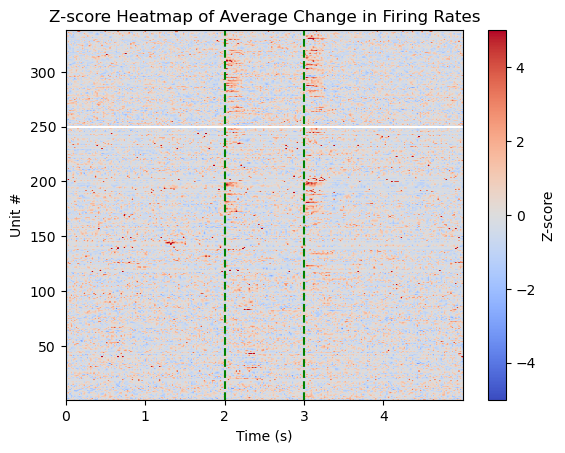

In [189]:
#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(goodSpikes)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * trial_duration)
        end_index = (j + 1) * int(sampleRate * trial_duration)

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)

plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unique_units)],
           cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')


# Extract units with z-scores over 2 between 1.9 and 2.1 seconds and plot z-maps
time_window_start = int(1.9 / bin_factor)
time_window_end = int(2.1 / bin_factor)
selected_units = unique_units[np.any(z_scored_change[:, time_window_start:time_window_end] > 2, axis=1)]
selected_units = list(map(int, selected_units))  # Convert to list of integers

print(selected_units)
plt.show()


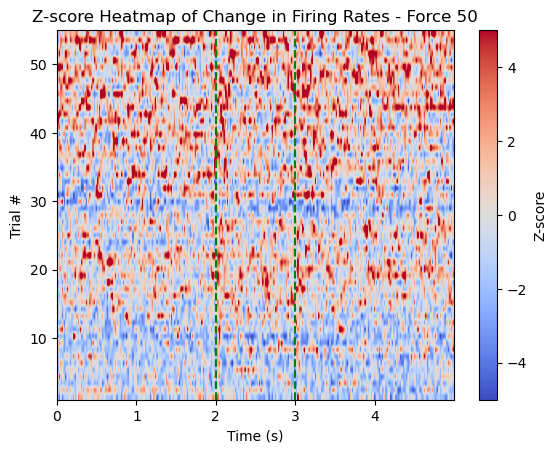

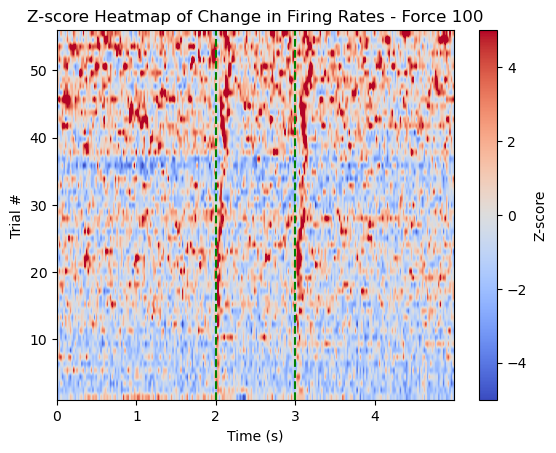

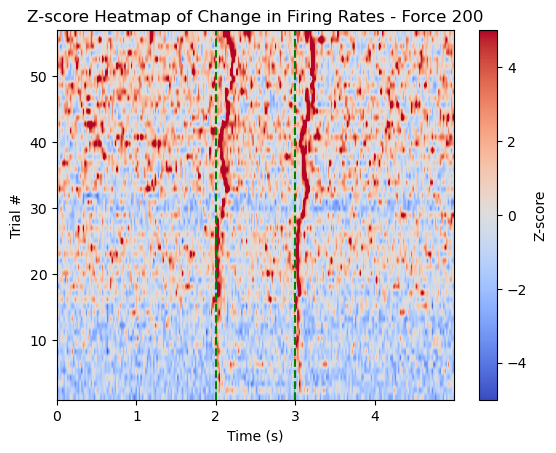

In [190]:
# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # Find indices within range
    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]



# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(mechTrialForce)

for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(mechTrialForce == force)[0]
    force_change_in_firing_rates = change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    
    # Plotting
    time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}')    
    plt.show()

    #print(baseline_firing_rates[:,0])

## 0.4 Plotting for physio experiment

In [138]:
settings = {
    'task_name' : 'physiologicalLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'trace_oi' : 4, # number (X) for trace of interest from "SA-LTMR example traces/saltmr_trace{X}.npy"
    'laser_duration' : 0.0003,  # seconds
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}

# calculate trial_duration and load example trace_array
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))
print(trial_duration)

277.0


In [39]:
physio = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\2024-01-03_ALC6_day1\00-npy files\physioLaser_20240103_134825_ao_data.npy"
physfile = np.load(physio)
print(len(physfile[0]))
print(((len(physfile[0])/30000)-2)/5)

8160000
54.0


In [57]:
acrec = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\2024-01-03_ALC6_day1\00-npy files\acRecField_20240103_134321_ao_data.npy"
acrecfile = np.load(acrec)
print(len(acrecfile[0]))
print(((len(acrecfile[0])/30000)-2)/5)

3600000
23.6


In [69]:
settings = {
    'task_name' : 'pulsedLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'laser_duration' : 0.0003,  # seconds
    'laser_frequency' : 40, # Hz (for sustained pulse, equate to settings['Fs']). **Run 5, 20, and 40Hz for full set**
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}


# calculate trial_duration
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))

train_onsets = np.arange((settings['trial_buffer']), (trial_duration), ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']

intervals = []

for i in range(len(train_onsets)-1):
    interval = train_onsets[i+1] - train_onsets[i]
    intervals.append(interval)

print(train_onsets)
print(trial_duration*30000)
print(np.unique(intervals))
print(165000/30000)

[  30000.  195000.  360000.  525000.  690000.  855000. 1020000. 1185000.
 1350000. 1515000. 1680000. 1845000. 2010000. 2175000. 2340000. 2505000.
 2670000. 2835000. 3000000. 3165000. 3330000. 3495000. 3660000. 3825000.
 3990000. 4155000. 4320000. 4485000. 4650000. 4815000. 4980000. 5145000.
 5310000. 5475000. 5640000. 5805000. 5970000. 6135000. 6300000. 6465000.
 6630000. 6795000. 6960000. 7125000. 7290000. 7455000. 7620000. 7785000.
 7950000. 8115000. 8280000.]
8310000.0
[165000.]
5.5


In [194]:
mech_duration = len(mechTrialForce) * 4.997 * 30000 #duration in samples
acRecField_duration = 3600000 #duration in samples
physio_duration = 8160000 #duration in samples

physio_start = mech_duration + acRecField_duration #start sample number
physio_end = physio_start + physio_duration #end sample number

physio_start_index = physio_start #+ int(1 * 30000) #add in buffer time


pulse_start = physio_start + physio_duration
pulse_end = pulse_start + physio_duration
print(physio_start_index)


28784880.0


In [206]:
#initial z-score for mech
# Define trial parameters
trial_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 150
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + pulse_start
    end_index = (i + 1) * int(sampleRate * trial_duration) + pulse_start

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

In [204]:
#initial z-score for mech
# Define trial parameters
trial_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * trial_duration) + physio_start_index

    # # Find indices within the specified range
    # indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # # Extract corresponding spike samples for all units
    # trial_spikes_all_units = [goodSamples[i] for i in indices_within_range]

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

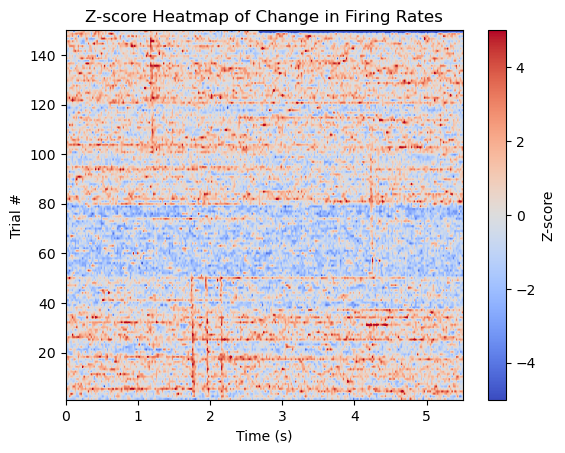

In [207]:
# Z-score the change in firing rates
#z_scored_change = zscore(change_in_firing_rates, axis=1)
z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
#plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
#plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

In [18]:
#y axis is units instead of trials
# Define trial parameters
trial_duration = 5  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 172
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(trial_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / bin_factor) - 1))  # Adjusted size
stimulation_signal = np.zeros((num_trials, int(sampleRate * trial_duration)))

# Create a dictionary to store firing rates for each unit
unit_firing_rates = {}
unit_baseline_rates = {}

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * trial_duration) + physio_start_index

    # # Find indices within the specified range
    # indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # # Extract corresponding spike samples and unit IDs for all units
    # trial_spikes_all_units = [goodSpikes[i] for i in indices_within_range]
    # trial_spikes_all_units = np.array(trial_spikes_all_units)

    trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]
    unique_units = np.unique(trial_spikes_all_units)

    # Calculate firing rates for each unit using np.histogram
    for unit_id in unique_units:
        unit_spikes = trial_spikes_all_units[trial_spikes_all_units == unit_id]

        firing_rates, bins = np.histogram(unit_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))
        unit_firing_rates.setdefault(unit_id, []).append(firing_rates[:num_bins])

        # Calculate the average firing rate from 2 seconds to the end
        baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
        unit_baseline_rates.setdefault(unit_id, []).append(baseline_firing_rate[:num_bins])

#takes about 1 minute

In [25]:
# Calculate the average change in firing rate for each unit across trials
average_unit_firing_rates = {unit_id: np.mean(unit_rates, axis=0) for unit_id, unit_rates in unit_firing_rates.items()}
average_unit_baseline_rates = {unit_id: np.mean(base_rates, axis=0) for unit_id, base_rates in unit_baseline_rates.items()}

# Convert the dictionary values to a 2D array for plotting
average_change_in_firing_rates = np.array(list(average_unit_firing_rates.values()))
average_change_in_baseline_rates = np.array(list(average_unit_baseline_rates.values()))

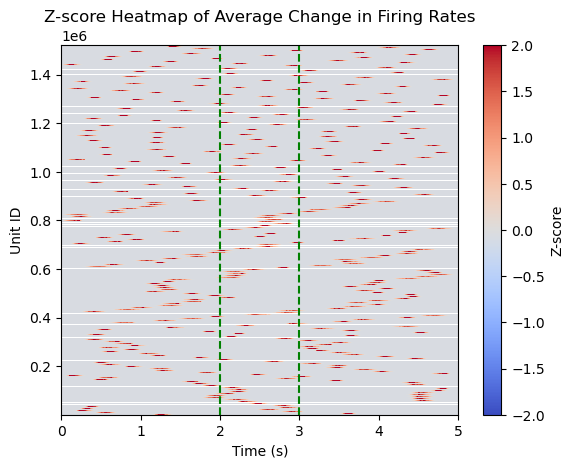

In [26]:
# Z-score the change in firing rates
#z_scored_change = zmap(average_change_in_firing_rates, average_change_in_baseline_rates, axis=0)
z_scored_change = zscore(average_change_in_firing_rates, axis=1)


# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / bin_factor) - 1)
unit_axis = list(average_unit_firing_rates.keys())

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unit_axis)], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap


# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')
plt.show()